In [361]:
import dill
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import FeatureUnion
from sklearn.cross_validation import train_test_split
import time
import matplotlib.pyplot as plt
import heapq
import re
import seaborn as sns
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
matplotlib.rc('xtick', labelsize=18) 
matplotlib.rc('ytick', labelsize=18)

In [ ]:
%matplotlib inline

In [197]:
transcripts = dill.load(open('../dills/debate_transcripts_list.dill', 'r'))
spectrum = pd.read_csv('../txt/huffpo_spectrum.txt',names=['firstname','lastname','rating'])
def lower2(s):
    return s.lower()

In [239]:
speakers = []# flattened dict of all candidates and their statements
statements = []
labels = [] # 0 for dem, 1 for republican
ratings = []
# all_statements = [] # list of all statements
for debate in transcripts:
    if debate != 0:
        for speaker in debate:
            year = speaker[-4:]
            if (year == '2015' or 
                year == '2016') and (
                speaker[2:-5].lower() in spectrum['lastname'].map(lower2).values
                ):
                #print speaker[2:-5]
                statement = ''.join(debate[speaker])
                speakers.append(speaker[2:-5])
                if speaker[0] == 'D':
                    labels.append('Dem')
                else:
                    labels.append('Rep')
                statements.append(statement)
                ratings.append(spectrum[spectrum['lastname'].map(lower2) == speaker[2:-5].lower()]['rating'].values[0])
            
df = pd.DataFrame([speakers, statements, labels, ratings],['Candidate','Statement','Label','Rating']).T

In [551]:
def wordcount(vec):
    return len(vec.split(' '))
#add a length vector
df['length'] = map(wordcount,df['Statement'])

#shuffle dataframe
dfshuf = df.reindex(np.random.permutation(df.index))

#slice large and small statements
traindf = dfshuf[dfshuf['length'] > 2750]
testdf = dfshuf[dfshuf['length'] < 2750]

In [552]:
len(traindf)

43

In [299]:
"""
First pipeline.

TfIdf -> SVD -> LinearRegression
"""
pipe = Pipeline(
    [
        ('tfidf', TfidfVectorizer()),
        ('svd', TruncatedSVD()),
        ('linear', LinearRegression())
    ]
)

parameters = {
    'tfidf__stop_words':['english',None],
    'tfidf__ngram_range':[(1,2)],
    'tfidf__min_df':[0.2,0.3,0.4],
    'tfidf__max_df':[0.9],
    'svd__n_components':[50,75,100]
}

# gridsearch with threefold cross validation
gscv = GridSearchCV(pipe, parameters, cv=3)

start = time.time() #timer start
# perform gridsearch
gscv.fit(traindf['Statement'], traindf['Rating'])
end = time.time()

# print results
print 'elapsed time: %.2f minutes' % ((end - start) / 60.)
print 'Best Score from Grid Search:',gscv.best_score_
print gscv.best_estimator_.named_steps

# name optimized model
linmod = gscv.best_estimator_

elapsed time: 0.66 minutes
Best Score from Grid Search: 0.911830952501
{'tfidf': TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=0.9, max_features=None, min_df=0.3,
        ngram_range=(1, 2), norm=u'l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern=u'(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None), 'svd': TruncatedSVD(algorithm='randomized', n_components=100, n_iter=5,
       random_state=None, tol=0.0), 'linear': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)}


In [297]:
"""
Second Pipeline. 

TfIdf -> SVD (with gridsearch optimized parameters)
"""

pipe2 = Pipeline(
    [
        ('tfidf', TfidfVectorizer()),
        ('svd', TruncatedSVD()),
        ('gboost', GradientBoostingRegressor())
    ]
)

# new gridsearch to determine optimal parameters for Gradient Boosted Trees
parameters = {
    'tfidf__max_df':[0.9],
    'tfidf__min_df':[0.2,0.4],
    'tfidf__ngram_range':[(1,2)],
    'svd__n_components':[50],
    'gboost__loss':['ls','lad','huber'],
    'gboost__learning_rate':[0.18,0.2,0.3],
    'gboost__n_estimators':[85,90,95], 
    'gboost__max_depth':[4,5]
}

gscv = GridSearchCV(pipe2, parameters, cv=3)

start = time.time() #timer start
# perform gridsearch
gscv.fit(traindf['Statement'], traindf['Rating'])
end = time.time()

# print results
print 'elapsed time: %.2f minutes' % ((end - start) / 60.)
print 'Best Score from Grid Search:',gscv.best_score_
print gscv.best_estimator_

# name optimized model
gbmod = gscv.best_estimator_

elapsed time: 5.21 minutes
Best Score from Grid Search: 0.904099825991
Pipeline(steps=[('tfidf', TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=0.9, max_features=None, min_df=0.4,
        ngram_range=(1, 2), norm=u'l2', preprocessor=None, smooth_idf=T...=0.0, n_estimators=85,
             random_state=None, subsample=1.0, verbose=0, warm_start=False))])


In [554]:
"""
Third Pipeline. 

TfIdf -> SVD -> RandomForest
"""

pipe2 = Pipeline(
    [
        ('tfidf', TfidfVectorizer()),
        ('svd', TruncatedSVD()),
        ('forest', RandomForestRegressor())
    ]
)

# new gridsearch to determine optimal parameters for Gradient Boosted Trees
parameters = {
    'tfidf__max_df':[0.9],
    'tfidf__min_df':[0.2,0.4],
    'tfidf__ngram_range':[(1,2)],
    'svd__n_components':[50],
    'forest__n_estimators':[85,90,95], 
    'forest__max_depth':[4,5]
}

gscv = GridSearchCV(pipe2, parameters, cv=3)

start = time.time() #timer start
# perform gridsearch
gscv.fit(traindf['Statement'], traindf['Rating'])
end = time.time()

# print results
print 'elapsed time: %.2f minutes' % ((end - start) / 60.)
print 'Best Score from Grid Search:',gscv.best_score_
print gscv.best_estimator_

# name optimized model
forestmod = gscv.best_estimator_

elapsed time: 0.56 minutes
Best Score from Grid Search: 0.977667850266
Pipeline(steps=[('tfidf', TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=0.9, max_features=None, min_df=0.4,
        ngram_range=(1, 2), norm=u'l2', preprocessor=None, smooth_idf=T...timators=95, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False))])


In [521]:
forestmod.named_steps

{'forest': RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
            max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=90, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
 'svd': TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
        random_state=None, tol=0.0),
 'tfidf': TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
         dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
         lowercase=True, max_df=0.9, max_features=None, min_df=0.4,
         ngram_range=(1, 2), norm=u'l2', preprocessor=None, smooth_idf=True,
         stop_words=None, strip_accents=None, sublinear_tf=False,
         token_pattern=u'(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
         vocabulary=None)}

In [608]:
linmod.named_steps

{'linear': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
 'svd': TruncatedSVD(algorithm='randomized', n_components=100, n_iter=5,
        random_state=None, tol=0.0),
 'tfidf': TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
         dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
         lowercase=True, max_df=0.9, max_features=None, min_df=0.3,
         ngram_range=(1, 2), norm=u'l2', preprocessor=None, smooth_idf=True,
         stop_words='english', strip_accents=None, sublinear_tf=False,
         token_pattern=u'(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
         vocabulary=None)}

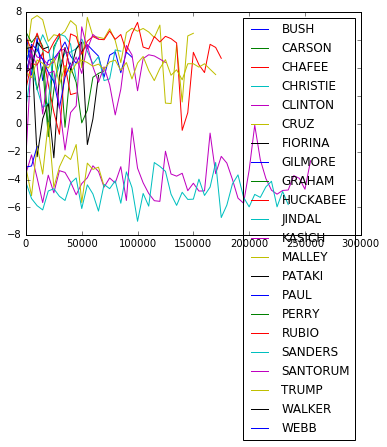

In [557]:
"""
See how the ideology prediction varies in time for each candidate.
"""
windowsize = 5000
stats = df[['Candidate','Statement']].groupby('Candidate').agg(sum)
most_lib = ''
most_cons = ''
maxim = 0
minim = 0
for i in range(len(stats)):
    stat = stats.iloc[i]['Statement']
    length = len(stat)
    name = stats.iloc[i].name
    x = []
    y = []
    for j in range(0,length-windowsize,windowsize):
        words = stat[j:j+windowsize]
        score = (linmod.predict([words]) + forestmod.predict([words])) / 2.
        x.append(j)
        y.append(score)
        if score > maxim:
            most_cons = words
            maxim = score
        if score < minim:
            most_lib = words
            minim = score
    plt.plot(x,y, label=name)
    plt.legend()
#print most_cons
#print 
#print most_lib

In [599]:
def predict_ideology(text, title='prediction'):
    """
    predicts the political spectrum value for a given chunk of text.
    plots this value on a -10 to 10 scale along with the values of
    several politicians for reference.
    """
    lm_pred = linmod.predict([text])
    rf_pred = forestmod.predict([text])
    
    # candidates and ratings to plot
    bignames = ('yourtext','Your text (random forest)','Your text',
                'Sanders','Clinton','Christie','Trump','Rubio','Cruz')
    ratings = [
        spectrum[spectrum['lastname'] == i]['rating'].values[0]
        for i in bignames[3:]
    ]
    y_pos = np.arange(len(bignames))
    
    cm = plt.get_cmap('RdBu') # colormap
    
    [plt.barh(a,b, 
             align='center', color=cm(1-(b+10)/20.), alpha=0.4) 
         for (a,b) in zip(y_pos[3:], ratings)]
    plt.barh(y_pos[2], (lm_pred+rf_pred) / 2., align='center', color=cm(1-(lm_pred+10)/20.), alpha=0.8)
    #plt.barh(y_pos[1], lm_pred, align='center', color=cm(1-(lm_pred+10)/20.), alpha=0.8)
    #plt.barh(y_pos[2], rf_pred, align='center', color=cm(1-(rf_pred+10)/20.), alpha=0.8)
    plt.yticks(y_pos[2:], bignames[2:])
    #plt.xlabel('Political Spectrum')
    plt.axis([-10,10,1,10])
    plt.text(-6.5,9,'LIBERAL', color=cm(0.99))
    plt.text(1.8,9,'CONSERVATIVE', color=cm(0.01))
    plt.fill_between([-10,10],[2.5,2.5],[1.5,1.5],color='black',alpha=0.2)
    plt.plot([0,0],[0,10],'-',color='black')
    plt.xticks([])
    plt.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.01)
    plt.savefig('../img/%s.png' % title,transparent=True)
    plt.show()

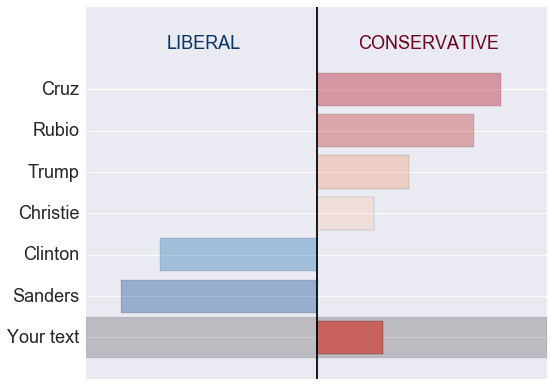

In [615]:
predict_ideology("""that's how you get a foreign policy where we cut 
                    deals with our enemies like Iran and we betray 
                    our allies like Israel""")

In [617]:
conservative_features[:3]

[(u'barack obama', 4.7225416782606837),
 (u'the law', 4.2016191237216152),
 (u'in chief', 4.1148786459460256)]

In [616]:
"""
Feature importance determination.
"""
all_statements = ' '.join(df['Statement'].values)
all_statements = all_statements.lower()
all_statments = re.sub(token_pattern, '', all_statements)
all_statements = re.sub(u',|\.|\'','',all_statements)
#all_statements = re.sub('|'.join(tfidf.get_stop_words()),'',all_statements)
all_statements = all_statements.split(' ')[:4000]
words = {}
for i in range(len(all_statements)-1):
    word = all_statements[i]
    word2 = ' '.join(all_statements[i:i+2])
    if word not in words:
        words[word] = model.predict([word])[0]
    if word2 not in words:
        words[word2] = model.predict([word2])[0]
    
conservative_features = sorted(words.items(), key=lambda x:x[1],reverse=True)[:100]

In [432]:
import dill
dill.dump(forestmod, open('../dills/forestmod.dill', 'wb'))
dill.dump(linmod, open('../dills/linmod.dill', 'wb'))

In [613]:
df.iloc[52]['Statement'][200:800] # Ru-Bi-OHHHHHHHH!

u"tates. [applause]Someone who cannot handle intelligence information appropriately cannot be commander in chief and someone who lies to the families of those four victims in Benghazi can never be president of the United States. Ever. [applause]On the issue of Barack Obama, Barack Obama does not believe that America is a great global power. Barack Obama believes that America is a arrogant global power that needs to be cut down to size. And that's how you get a foreign policy where we cut deals with our enemies like Iran and we betray our allies like Israel and we gut our military and we go aroun"